In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

## Check for CUDA

In [2]:
# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available!")
else:
    print("GPU is not available. Using CPU.")
    
# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available!
Using device: cuda


## Download data

In [3]:
celeba = torchvision.datasets.CelebA(root='./', download=True)

Files already downloaded and verified


In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to a consistent size
    transforms.ToTensor(),  # Convert PIL Images to tensors
])

# Assuming celeba is your dataset, apply the transform
celeba.transform = transform

In [5]:
celeb_loader = torch.utils.data.DataLoader(celeba,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=12)

## Plot a batch

In [6]:
import matplotlib.pyplot as plt
def show_celeb_batch(images):
    """
    Display a batch of CelebA images with their corresponding names
    
    Args:
        images (torch.Tensor): Batch of images (B x C x H x W)
        names (list): List of names corresponding to the images
    """
    # Convert images from tensor to numpy array
    images = images.numpy()
    
    # Move channel dimension to end for plotting (B x H x W x C)
    images = np.transpose(images, (0, 2, 3, 1))
    
    # Get number of images in batch
    batch_size = images.shape[0]
    
    # Create figure
    fig, axes = plt.subplots(1, batch_size, figsize=(12, 3))
    if batch_size == 1:
        axes = [axes]
    
    # Plot each image with its name
    for idx, (img, ax) in enumerate(zip(images, axes)):
        ax.imshow(img)
        ax.axis('off')
    
    plt.tight_layout()
    return fig

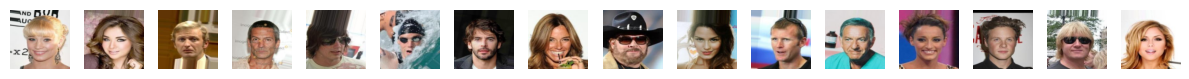

In [7]:
# Get a batch of images and their corresponding names
dataiter = iter(celeb_loader)
images, _ = next(dataiter)
images = images.to(device)

# Show the batch
fig = show_celeb_batch(images.cpu())
plt.show()


In [8]:
print("Image shape: ",images.shape)
print(f"Max pixel value: {images.max()}, Min pixel value: {images.min()}")

Image shape:  torch.Size([16, 3, 128, 128])
Max pixel value: 1.0, Min pixel value: 0.0


## Create VAE architecture

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def init_weights(m):
    """Initialize weights for convolutional and linear layers."""
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            # He initialization for convolutional layers with ReLU/LeakyReLU
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        elif isinstance(m, nn.Linear):
            # He initialization for linear layers with ReLU/LeakyReLU
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)  # Initialize biases to 0

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # Layer 1: 128x128x3 → 64x64x64
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(negative_slope=0.01),
        )
        # Layer 2: 64x64x64 → 32x32x128
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.01),
        )
        # Layer 3: 32x32x128 → 16x16x256
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(negative_slope=0.01),
        )
        # Layer 4: 16x16x256 → 8x8x512
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(negative_slope=0.01),
        )
        # Layer 5: 8x8x512 → 4x4x1024
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=1024),
            nn.LeakyReLU(negative_slope=0.01),
        )
        self.mean_lin = nn.Linear(in_features=1024 * 4 * 4, out_features=1024)  # Latent dim = 1024
        self.logvar_lin = nn.Linear(in_features=1024 * 4 * 4, out_features=1024)  # Latent dim = 1024
        
        # Initialize weights
        self.apply(init_weights)
        
    def forward(self, x):
        # Save feature maps for skip connections
        x1 = self.conv1(x)  # 64x64x64
        x2 = self.conv2(x1)  # 32x32x128
        x3 = self.conv3(x2)  # 16x16x256
        x4 = self.conv4(x3)  # 8x8x512
        x5 = self.conv5(x4)  # 4x4x1024
        
        x5 = torch.flatten(x5, start_dim=1)  # Flatten to (batch_size, 1024 * 4 * 4)
        mean = self.mean_lin(x5)
        logvar = self.logvar_lin(x5)
        return mean, logvar, [x1, x2, x3, x4]  # Return feature maps for skip connections

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.input = nn.Linear(1024, 1024 * 4 * 4)  # Match latent_dim=1024
        
        # Layer 1: 4x4x1024 → 8x8x1024
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
        )
        # Layer 2: 8x8x1024 + 8x8x512 → 16x16x512
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024 + 512, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
        )
        # Layer 3: 16x16x512 + 16x16x256 → 32x32x256
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512 + 256, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
        )
        # Layer 4: 32x32x256 + 32x32x128 → 64x64x128
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256 + 128, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
        )
        # Layer 5: 64x64x128 + 64x64x64 → 128x128x64
        self.conv5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128 + 64, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
        )
        # Layer 6: 128x128x64 → 128x128x3
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),  # Output in range [0, 1]
        )
        
        # Initialize weights
        self.apply(init_weights)
    
    def forward(self, x, skip_connections):
        x = self.input(x)
        x = x.view(-1, 1024, 4, 4)  # Reshape to (batch_size, 1024, 4, 4)
        
        # Decoder with skip connections
        x = self.conv1(x)  # 8x8x1024
        x = torch.cat([x, skip_connections[3]], dim=1)  # Concatenate with encoder feature map (8x8x512)
        x = self.conv2(x)  # 16x16x512
        x = torch.cat([x, skip_connections[2]], dim=1)  # Concatenate with encoder feature map (16x16x256)
        x = self.conv3(x)  # 32x32x256
        x = torch.cat([x, skip_connections[1]], dim=1)  # Concatenate with encoder feature map (32x32x128)
        x = self.conv4(x)  # 64x64x128
        x = torch.cat([x, skip_connections[0]], dim=1)  # Concatenate with encoder feature map (64x64x64)
        x = self.conv5(x)  # 128x128x64
        x = self.conv6(x)  # 128x128x3
        return x

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.enc = Encoder()
        self.dec = Decoder()
        
    def forward(self, x):
        mean, logvar, skip_connections = self.enc(x)  # Get skip connections from encoder
        std = torch.exp(0.5 * logvar) + 1e-8  # Numerical stability
        eps = torch.randn_like(std)
        latent_samples = mean + eps * std
        out = self.dec(latent_samples, skip_connections)  # Pass skip connections to decoder
        return mean, logvar, out

In [10]:
vae = VAE().to(device)

In [11]:
mean, std, out = vae(images)

In [12]:
mean.shape, std.shape, out.shape
out = out.detach()

## Plot out of untrained VAE

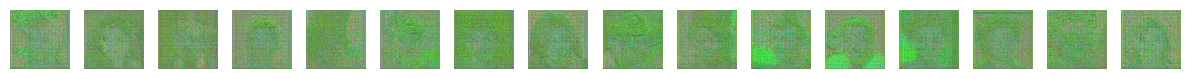

Image shape:  torch.Size([16, 3, 128, 128])
Max pixel value: 0.9978055357933044, Min pixel value: 0.0020464297849684954


In [13]:
# Show the vae output batch
fig = show_celeb_batch(out.cpu())
plt.show()
print("Image shape: ",out.shape)
print(f"Max pixel value: {out.max()}, Min pixel value: {out.min()}")

## Create loss function

In [14]:
## 2 parts to loss BCE and KL divergence
def loss(target_image, predicted_image, mean, logvar, beta):
    bce_loss = F.binary_cross_entropy(predicted_image, target_image, reduction='mean')
    kldiv_loss = -0.5*torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    # print(f"BCE Loss: {bce_loss.item()}, KL Divergence Loss: {kldiv_loss.item()}")
    total_loss = bce_loss + beta*kldiv_loss
    return bce_loss, kldiv_loss, total_loss

## Training loop

In [15]:
import matplotlib.pyplot as plt

def visualize_reconstructions(target_images, reconstructed_images, num_images=4):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    for i in range(num_images):
        # Original image
        axes[0, i].imshow(target_images[i].permute(1, 2, 0).cpu().numpy())
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        # Reconstructed image
        axes[1, i].imshow(reconstructed_images[i].permute(1, 2, 0).cpu().numpy())
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    plt.show()

Epoch [1/10], Batch [0/10174], BCE: 0.4476, KL: 0.1085, Loss: 0.4487
Epoch [1/10], Batch [1000/10174], BCE: 0.4933, KL: 0.1178, Loss: 0.4944
Epoch [1/10], Batch [2000/10174], BCE: 0.4524, KL: 0.1818, Loss: 0.4542
Epoch [1/10], Batch [3000/10174], BCE: 0.4830, KL: 0.0177, Loss: 0.4832
Epoch [1/10], Batch [4000/10174], BCE: 0.4552, KL: 0.3900, Loss: 0.4591
Epoch [1/10], Batch [5000/10174], BCE: 0.5159, KL: 0.0709, Loss: 0.5166
Epoch [1/10], Batch [6000/10174], BCE: 0.4476, KL: 0.1170, Loss: 0.4488
Epoch [1/10], Batch [7000/10174], BCE: 0.4872, KL: 0.1451, Loss: 0.4886
Epoch [1/10], Batch [8000/10174], BCE: 0.5085, KL: 0.0288, Loss: 0.5088
Epoch [1/10], Batch [9000/10174], BCE: 0.4964, KL: 0.1110, Loss: 0.4975
Epoch [1/10], Batch [10000/10174], BCE: 0.4407, KL: 0.0446, Loss: 0.4411
Epoch [1/10], Avg BCE Loss: 0.4759, Avg KL Div Loss: 2.1948, Avg Loss: 0.4978


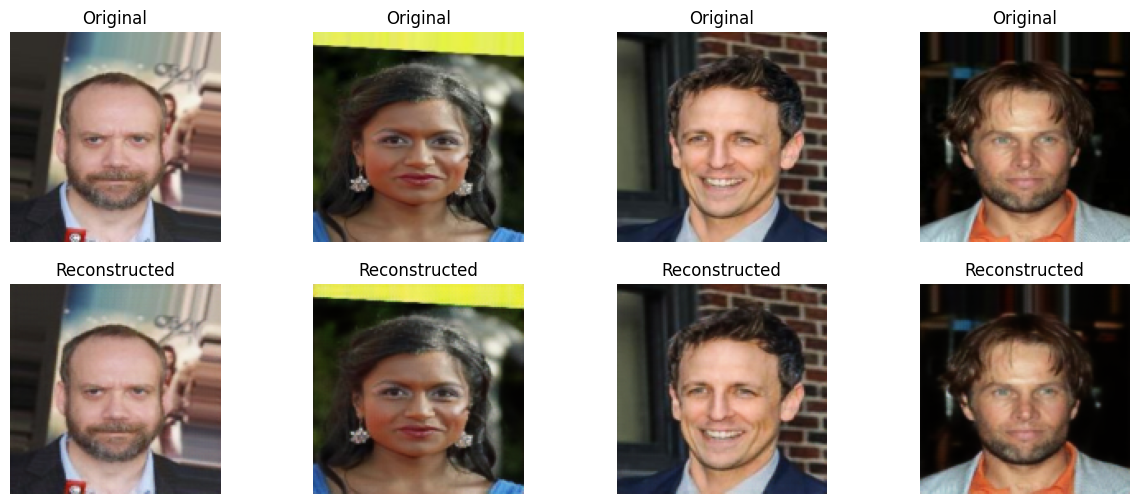

Epoch [2/10], Batch [0/10174], BCE: 0.4992, KL: 0.0101, Loss: 0.4993
Epoch [2/10], Batch [1000/10174], BCE: 0.5137, KL: 0.0158, Loss: 0.5139
Epoch [2/10], Batch [2000/10174], BCE: 0.4766, KL: 0.0147, Loss: 0.4768
Epoch [2/10], Batch [3000/10174], BCE: 0.4962, KL: 0.0015, Loss: 0.4962
Epoch [2/10], Batch [4000/10174], BCE: 0.4884, KL: 0.0013, Loss: 0.4885
Epoch [2/10], Batch [5000/10174], BCE: 0.4312, KL: 0.0263, Loss: 0.4315
Epoch [2/10], Batch [6000/10174], BCE: 0.4537, KL: 0.0110, Loss: 0.4538
Epoch [2/10], Batch [7000/10174], BCE: 0.4695, KL: 0.0024, Loss: 0.4695
Epoch [2/10], Batch [8000/10174], BCE: 0.4870, KL: 0.0521, Loss: 0.4875
Epoch [2/10], Batch [9000/10174], BCE: 0.4828, KL: 0.0097, Loss: 0.4829
Epoch [2/10], Batch [10000/10174], BCE: 0.4832, KL: 1.5019, Loss: 0.4982
Epoch [2/10], Avg BCE Loss: 0.4754, Avg KL Div Loss: 0.7147, Avg Loss: 0.4826


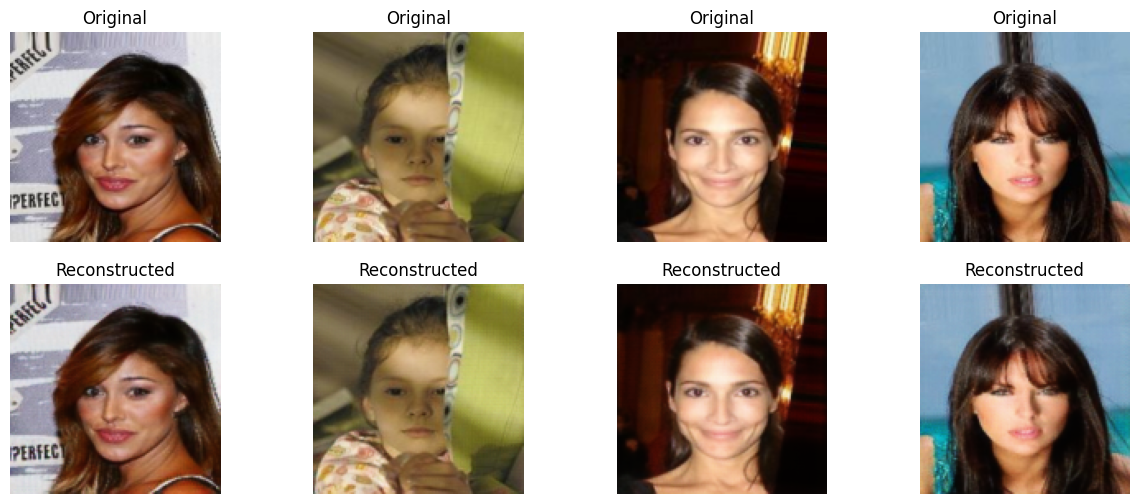

Epoch [3/10], Batch [0/10174], BCE: 0.4856, KL: 0.8726, Loss: 0.4943
Epoch [3/10], Batch [1000/10174], BCE: 0.5237, KL: 0.0707, Loss: 0.5244
Epoch [3/10], Batch [2000/10174], BCE: 0.4693, KL: 0.0143, Loss: 0.4695
Epoch [3/10], Batch [3000/10174], BCE: 0.4896, KL: 0.0606, Loss: 0.4902
Epoch [3/10], Batch [4000/10174], BCE: 0.4512, KL: 0.0030, Loss: 0.4512
Epoch [3/10], Batch [5000/10174], BCE: 0.4606, KL: 0.0034, Loss: 0.4606
Epoch [3/10], Batch [6000/10174], BCE: 0.4988, KL: 0.0023, Loss: 0.4988
Epoch [3/10], Batch [7000/10174], BCE: 0.4406, KL: 0.0074, Loss: 0.4406
Epoch [3/10], Batch [8000/10174], BCE: 0.4952, KL: 0.0471, Loss: 0.4957
Epoch [3/10], Batch [9000/10174], BCE: 0.4572, KL: 0.0054, Loss: 0.4573
Epoch [3/10], Batch [10000/10174], BCE: 0.4547, KL: 0.0084, Loss: 0.4548
Epoch [3/10], Avg BCE Loss: 0.4752, Avg KL Div Loss: 0.1312, Avg Loss: 0.4765


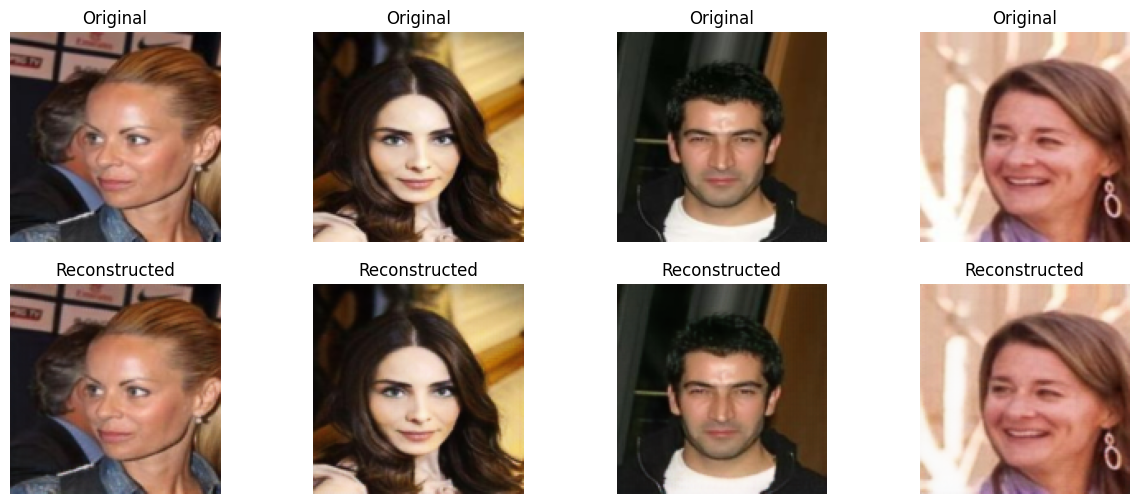

Epoch [4/10], Batch [0/10174], BCE: 0.4626, KL: 0.1563, Loss: 0.4642
Epoch [4/10], Batch [1000/10174], BCE: 0.4577, KL: 0.0043, Loss: 0.4577
Epoch [4/10], Batch [2000/10174], BCE: 0.4611, KL: 0.0027, Loss: 0.4611
Epoch [4/10], Batch [3000/10174], BCE: 0.4466, KL: 0.0019, Loss: 0.4466
Epoch [4/10], Batch [4000/10174], BCE: 0.5267, KL: 0.0015, Loss: 0.5267
Epoch [4/10], Batch [5000/10174], BCE: 0.4519, KL: 0.0079, Loss: 0.4520
Epoch [4/10], Batch [6000/10174], BCE: 0.4746, KL: 0.0348, Loss: 0.4750
Epoch [4/10], Batch [7000/10174], BCE: 0.5094, KL: 0.5408, Loss: 0.5148
Epoch [4/10], Batch [8000/10174], BCE: 0.5013, KL: 0.0779, Loss: 0.5021
Epoch [4/10], Batch [9000/10174], BCE: 0.4834, KL: 0.0086, Loss: 0.4835
Epoch [4/10], Batch [10000/10174], BCE: 0.5070, KL: 0.2101, Loss: 0.5091
Epoch [4/10], Avg BCE Loss: 0.4751, Avg KL Div Loss: 1.1742, Avg Loss: 0.4868


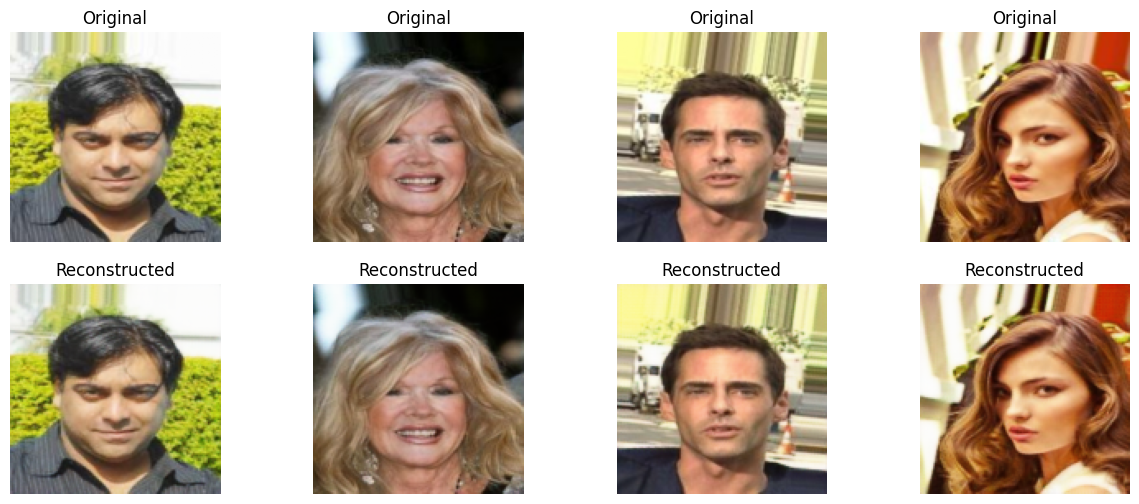

Epoch [5/10], Batch [0/10174], BCE: 0.4752, KL: 0.0212, Loss: 0.4755
Epoch [5/10], Batch [1000/10174], BCE: 0.4846, KL: 0.0020, Loss: 0.4847
Epoch [5/10], Batch [2000/10174], BCE: 0.4364, KL: 0.0030, Loss: 0.4364
Epoch [5/10], Batch [3000/10174], BCE: 0.4857, KL: 0.0041, Loss: 0.4857
Epoch [5/10], Batch [4000/10174], BCE: 0.4290, KL: 0.0013, Loss: 0.4290
Epoch [5/10], Batch [5000/10174], BCE: 0.5043, KL: 0.0110, Loss: 0.5044
Epoch [5/10], Batch [6000/10174], BCE: 0.4859, KL: 0.0073, Loss: 0.4860
Epoch [5/10], Batch [7000/10174], BCE: 0.4928, KL: 0.0034, Loss: 0.4928
Epoch [5/10], Batch [8000/10174], BCE: 0.5035, KL: 0.0112, Loss: 0.5036
Epoch [5/10], Batch [9000/10174], BCE: 0.4406, KL: 0.0136, Loss: 0.4407
Epoch [5/10], Batch [10000/10174], BCE: 0.4933, KL: 0.0037, Loss: 0.4933
Epoch [5/10], Avg BCE Loss: 0.4749, Avg KL Div Loss: 0.0409, Avg Loss: 0.4753


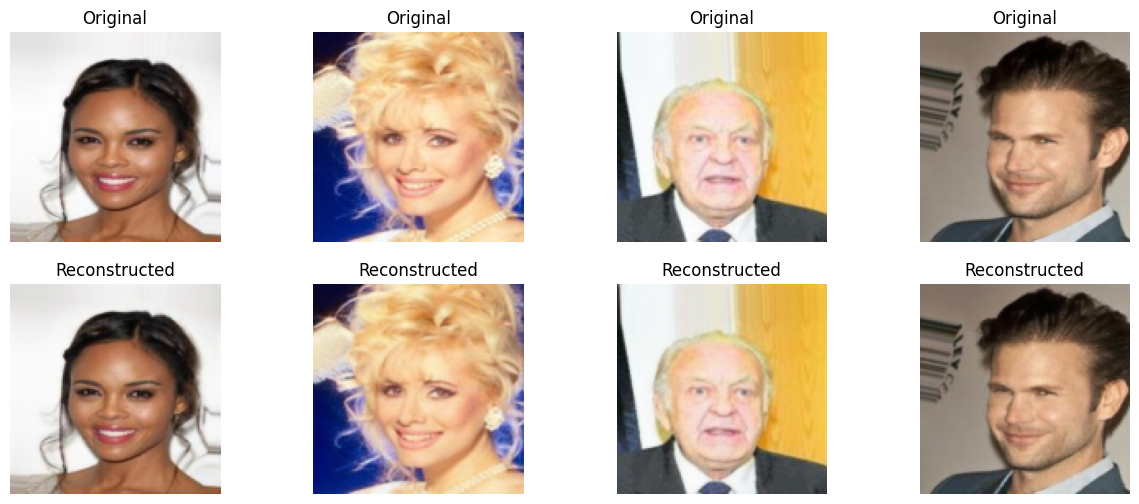

Epoch [6/10], Batch [0/10174], BCE: 0.5089, KL: 0.0017, Loss: 0.5090
Epoch [6/10], Batch [1000/10174], BCE: 0.4910, KL: 0.0013, Loss: 0.4910
Epoch [6/10], Batch [2000/10174], BCE: 0.4882, KL: 0.0016, Loss: 0.4882
Epoch [6/10], Batch [3000/10174], BCE: 0.5272, KL: 0.0007, Loss: 0.5272
Epoch [6/10], Batch [4000/10174], BCE: 0.4525, KL: 0.0048, Loss: 0.4525
Epoch [6/10], Batch [5000/10174], BCE: 0.5164, KL: 0.0031, Loss: 0.5164
Epoch [6/10], Batch [6000/10174], BCE: 0.5088, KL: 0.0129, Loss: 0.5089
Epoch [6/10], Batch [7000/10174], BCE: 0.4656, KL: 0.1481, Loss: 0.4671
Epoch [6/10], Batch [8000/10174], BCE: 0.4829, KL: 0.0012, Loss: 0.4830
Epoch [6/10], Batch [9000/10174], BCE: 0.4476, KL: 0.0061, Loss: 0.4476
Epoch [6/10], Batch [10000/10174], BCE: 0.4539, KL: 0.0008, Loss: 0.4539
Epoch [6/10], Avg BCE Loss: 0.4748, Avg KL Div Loss: 0.0271, Avg Loss: 0.4750


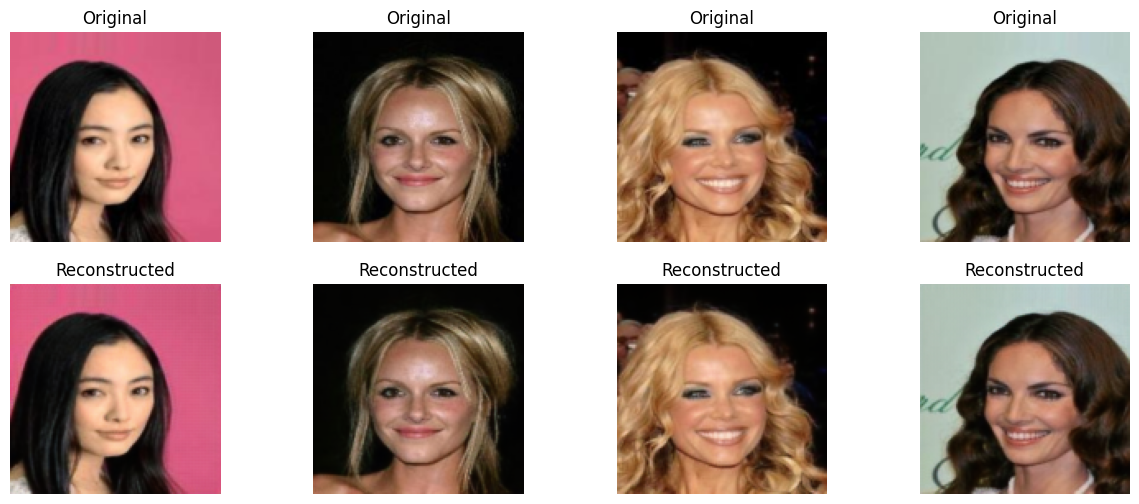

Epoch [7/10], Batch [0/10174], BCE: 0.4583, KL: 0.0147, Loss: 0.4585
Epoch [7/10], Batch [1000/10174], BCE: 0.5107, KL: 0.0007, Loss: 0.5107
Epoch [7/10], Batch [2000/10174], BCE: 0.4826, KL: 0.0008, Loss: 0.4826
Epoch [7/10], Batch [3000/10174], BCE: 0.4921, KL: 0.0019, Loss: 0.4922
Epoch [7/10], Batch [4000/10174], BCE: 0.5130, KL: 0.0113, Loss: 0.5131
Epoch [7/10], Batch [5000/10174], BCE: 0.4719, KL: 0.0100, Loss: 0.4720
Epoch [7/10], Batch [6000/10174], BCE: 0.4568, KL: 0.0022, Loss: 0.4568
Epoch [7/10], Batch [7000/10174], BCE: 0.4650, KL: 0.0152, Loss: 0.4651
Epoch [7/10], Batch [8000/10174], BCE: 0.4491, KL: 0.0012, Loss: 0.4491
Epoch [7/10], Batch [9000/10174], BCE: 0.4545, KL: 0.0048, Loss: 0.4545
Epoch [7/10], Batch [10000/10174], BCE: 0.4552, KL: 0.0013, Loss: 0.4553
Epoch [7/10], Avg BCE Loss: 0.4747, Avg KL Div Loss: 0.0495, Avg Loss: 0.4752


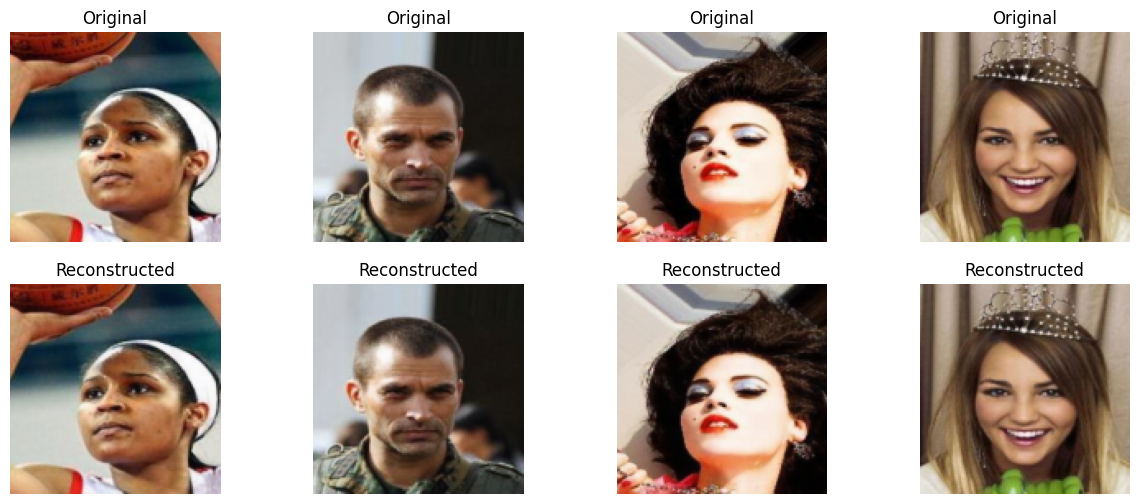

Epoch [8/10], Batch [0/10174], BCE: 0.4843, KL: 0.1952, Loss: 0.4863
Epoch [8/10], Batch [1000/10174], BCE: 0.4553, KL: 0.0047, Loss: 0.4553
Epoch [8/10], Batch [2000/10174], BCE: 0.4716, KL: 0.0101, Loss: 0.4717
Epoch [8/10], Batch [3000/10174], BCE: 0.4494, KL: 0.0108, Loss: 0.4495
Epoch [8/10], Batch [4000/10174], BCE: 0.4970, KL: 0.0210, Loss: 0.4972
Epoch [8/10], Batch [5000/10174], BCE: 0.4445, KL: 0.0021, Loss: 0.4445
Epoch [8/10], Batch [6000/10174], BCE: 0.4623, KL: 0.0082, Loss: 0.4623
Epoch [8/10], Batch [7000/10174], BCE: 0.4956, KL: 0.0205, Loss: 0.4958
Epoch [8/10], Batch [8000/10174], BCE: 0.4971, KL: 0.2552, Loss: 0.4996
Epoch [8/10], Batch [9000/10174], BCE: 0.5209, KL: 0.0022, Loss: 0.5209
Epoch [8/10], Batch [10000/10174], BCE: 0.4796, KL: 0.0004, Loss: 0.4796
Epoch [8/10], Avg BCE Loss: 0.4746, Avg KL Div Loss: 0.0199, Avg Loss: 0.4748


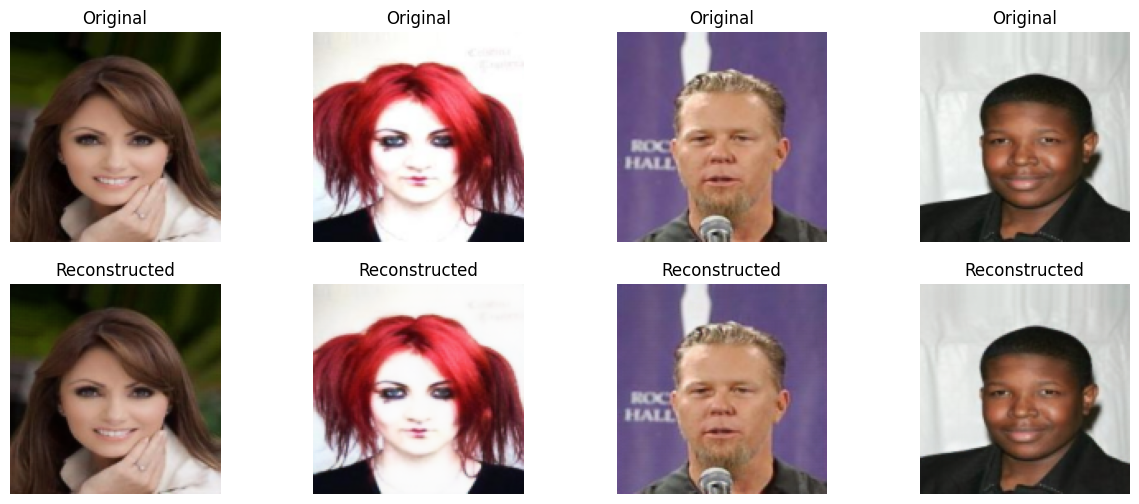

Epoch [9/10], Batch [0/10174], BCE: 0.4809, KL: 0.0022, Loss: 0.4809
Epoch [9/10], Batch [1000/10174], BCE: 0.4722, KL: 0.0107, Loss: 0.4723
Epoch [9/10], Batch [2000/10174], BCE: 0.4511, KL: 0.0010, Loss: 0.4511
Epoch [9/10], Batch [3000/10174], BCE: 0.5104, KL: 0.1214, Loss: 0.5116
Epoch [9/10], Batch [4000/10174], BCE: 0.4508, KL: 0.0004, Loss: 0.4508
Epoch [9/10], Batch [5000/10174], BCE: 0.4383, KL: 0.0011, Loss: 0.4383
Epoch [9/10], Batch [6000/10174], BCE: 0.4538, KL: 0.0011, Loss: 0.4538
Epoch [9/10], Batch [7000/10174], BCE: 0.4995, KL: 0.0027, Loss: 0.4995
Epoch [9/10], Batch [8000/10174], BCE: 0.4798, KL: 0.0002, Loss: 0.4798
Epoch [9/10], Batch [9000/10174], BCE: 0.4720, KL: 0.0014, Loss: 0.4720
Epoch [9/10], Batch [10000/10174], BCE: 0.4900, KL: 0.0095, Loss: 0.4901
Epoch [9/10], Avg BCE Loss: 0.4745, Avg KL Div Loss: 0.0243, Avg Loss: 0.4747


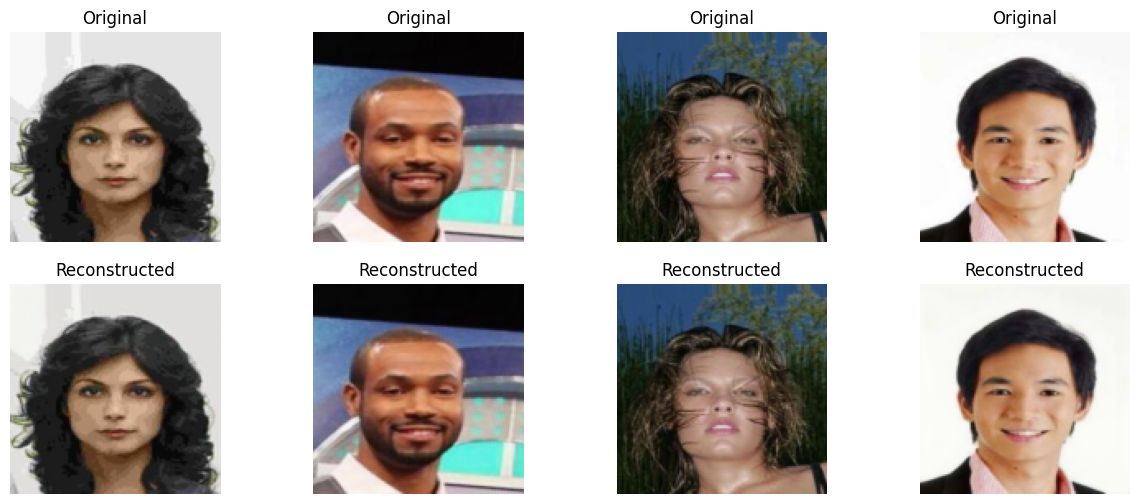

Epoch [10/10], Batch [0/10174], BCE: 0.4894, KL: 0.0037, Loss: 0.4894
Epoch [10/10], Batch [1000/10174], BCE: 0.4525, KL: 0.0026, Loss: 0.4525
Epoch [10/10], Batch [2000/10174], BCE: 0.4749, KL: 0.0004, Loss: 0.4749
Epoch [10/10], Batch [3000/10174], BCE: 0.4954, KL: 0.0013, Loss: 0.4954
Epoch [10/10], Batch [4000/10174], BCE: 0.4887, KL: 0.0007, Loss: 0.4887
Epoch [10/10], Batch [5000/10174], BCE: 0.4724, KL: 0.0018, Loss: 0.4725
Epoch [10/10], Batch [6000/10174], BCE: 0.4847, KL: 0.0582, Loss: 0.4853
Epoch [10/10], Batch [7000/10174], BCE: 0.4689, KL: 0.0004, Loss: 0.4689
Epoch [10/10], Batch [8000/10174], BCE: 0.4278, KL: 0.0023, Loss: 0.4278
Epoch [10/10], Batch [9000/10174], BCE: 0.4706, KL: 0.0015, Loss: 0.4706
Epoch [10/10], Batch [10000/10174], BCE: 0.4763, KL: 0.0025, Loss: 0.4763
Epoch [10/10], Avg BCE Loss: 0.4744, Avg KL Div Loss: 0.0108, Avg Loss: 0.4746


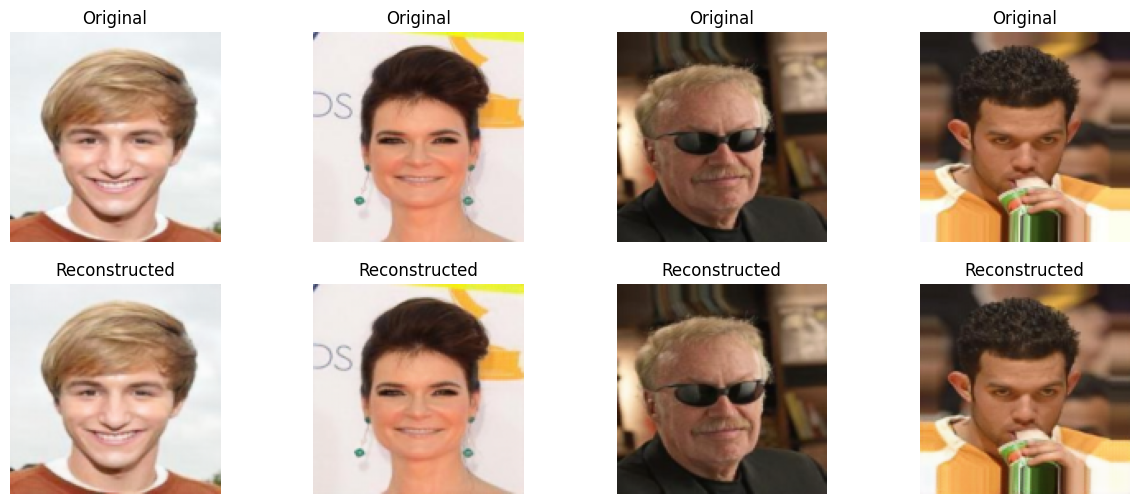

In [ ]:
import torch.optim as optim
num_epochs = 10
beta = 0.01
optimizer = optim.Adam(vae.parameters(), lr=1e-4)  # Increased learning rate

# Training loop
for epoch in range(num_epochs):
    vae.train()  # Set model to training mode
    epoch_bce_loss = 0.0
    epoch_kldiv_loss = 0.0
    epoch_total_loss = 0.0
    
    # Iterate over all batches in the dataset
    for batch_idx, (images, _) in enumerate(celeb_loader):
        # Move images to the appropriate device
        images = images.to(device)
        
        # Forward pass
        mean, logvar, predicted_images = vae(images)
        
        # Compute loss
        bce_loss, kldiv_loss, total_loss = loss(images, predicted_images, mean, logvar, beta=beta)
        
        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # Print every N batches
        if batch_idx % 1000 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx}/{len(celeb_loader)}], "
                  f"BCE: {bce_loss:.4f}, KL: {kldiv_loss:.4f}, Loss: {total_loss:.4f}")
        
        # Accumulate losses for logging
        epoch_bce_loss += bce_loss.item()
        epoch_kldiv_loss += kldiv_loss.item()
        epoch_total_loss += total_loss.item()
    
    # Print average losses for the epoch
    num_batches = len(celeb_loader)
    avg_bce_loss = epoch_bce_loss / num_batches
    avg_kldiv_loss = epoch_kldiv_loss / num_batches
    avg_total_loss = epoch_total_loss / num_batches
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Avg BCE Loss: {avg_bce_loss:.4f}, "
          f"Avg KL Div Loss: {avg_kldiv_loss:.4f}, "
          f"Avg Loss: {avg_total_loss:.4f}")
    
    # Visualize reconstructions periodically (e.g., every 10 epochs)
    if (epoch + 1) % 1 == 0:
        vae.eval()  # Set model to evaluation mode
        with torch.no_grad():
            # Use a fixed batch for visualization (e.g., the first batch)
            fixed_images, _ = next(iter(celeb_loader))
            fixed_images = fixed_images.to(device)
            _, _, reconstructed_images = vae(fixed_images)
            visualize_reconstructions(fixed_images, reconstructed_images)
        vae.train()  # Set model back to training mode

## Save model

In [ ]:
# Save model
torch.save(vae.state_dict(), 'vae_weights.pth')